# Random Forests

- Random Forests
- Sklearn Pipelines
- Hyperparameters Tuning and cross validation

In [1]:
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.inspection import DecisionBoundaryDisplay


sns.set_style('darkgrid')

## Toy Example

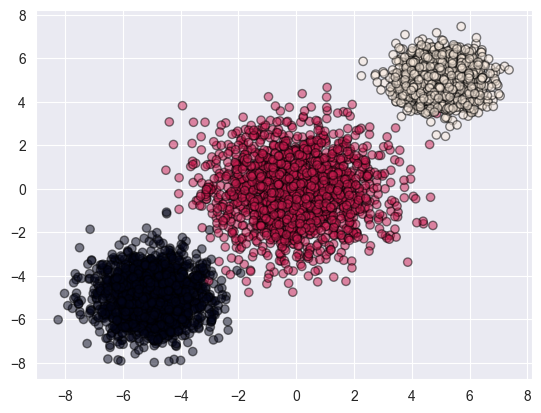

In [2]:
N_SAMPLES = 5000

X, y = make_blobs(
    n_samples=N_SAMPLES,
    cluster_std=[1.0, 1.5, 0.7],
    centers=[(-5, -5), (0, 0), (5, 5)],
    random_state=42,
)

plt.scatter(X[:, 0], X[:, 1], c=y, alpha=.5, edgecolor="k")

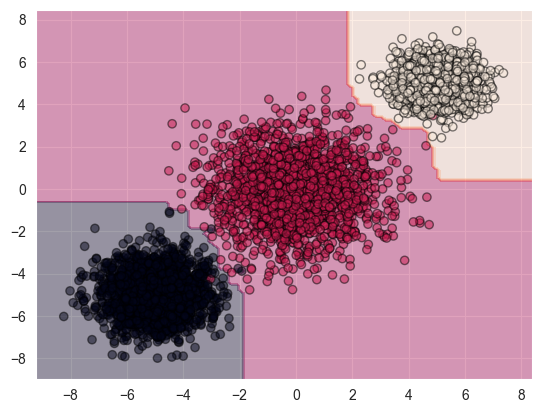

In [3]:
rf = RandomForestClassifier(random_state=42).fit(X, y)


DecisionBoundaryDisplay.from_estimator(
    rf, X, response_method="predict", alpha=0.4
)
plt.scatter(X[:, 0], X[:, 1], c=y, alpha=.5, edgecolor="k")

## Sklearn Pipelines

The idea is to chain tasks/estimators. Examples:
- Any preprocessing like scaling/imputations/outliers removal, and
- training the model

In [4]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

In [5]:
wdf = pd.read_csv("./data/weatherAUS.csv")

In [6]:
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

target_col = "RainTomorrow"

def get_null_accuracy(df):
    null_acc = df[target_col].value_counts()/len(df)
    print(f"Null accuracy: {null_acc.max() * 100: .2f}%")
    return null_acc

def split_data(df):
    df0 = df.dropna(subset=[target_col])
    X = df0.drop([target_col], axis=1)
    y = df0[target_col].apply(lambda y: 1 if y and y.lower() == 'yes' else 0)

    return train_test_split(X, y, test_size = 0.2, random_state = 0)


def fit_and_evaluate(model, X_train, y_train, X_test, y_test):
    model = model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print(f'Train accuracy score: {accuracy_score(y_train, model.predict(X_train)) * 100:.2f}%')
    print(f'Test accuracy score: {accuracy_score(y_test, y_pred) * 100:0.2f}%')
    
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()
    plt.show()
    return model

In [7]:
from sklearn.base import BaseEstimator, TransformerMixin

class ColumnSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, dtype):
        self.dtype = dtype
    
    def fit(self, X, y=None):
        """ Get either categorical or numerical columns on fit.
        Store as attribute for future reference"""
        df = X if isinstance(X, pd.DataFrame) else pd.DataFrame(X)
        if self.dtype == 'numerical':
            self.cols = df.select_dtypes(exclude='O').columns.tolist()
        elif self.dtype == 'categorical':
            self.cols = df.select_dtypes(include='O').columns.tolist()
        self.col_idx = [df.columns.get_loc(col) for col in self.cols]
        return self

    def transform(self, X):
        """ Subset columns of chosen data type and return np.array"""
        X = X.values if isinstance(X, pd.DataFrame) else X
        return X[:, self.col_idx]


In [8]:
num_pipe = Pipeline([
    ('num_selector', ColumnSelector('numerical')),
    ('num_imputer', SimpleImputer(strategy='constant', fill_value=0))
])

cat_pipe = Pipeline([
    ('cat_selector', ColumnSelector('categorical')),
    ('cat_imputer', SimpleImputer(strategy='constant', fill_value='None')),
    # ('ohe', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

preproc_pipeline = FeatureUnion([
    ('num_pipe', num_pipe),
    ('cat_pipe', cat_pipe)
])

In [9]:
print("Number of missing values: ", wdf.isnull().sum().sum())

Number of missing values:  343248


In [10]:
imputed_df = preproc_pipeline.fit_transform(wdf)
print("Number of missing values: ", pd.DataFrame(imputed_df).isnull().sum().sum())

Number of missing values:  0


In [11]:
preproc_pipeline.get_params()["cat_pipe"].steps.append(
    ('ohe', OneHotEncoder(sparse_output=True, handle_unknown='ignore'))
)

In [12]:
estimator_pipeline = Pipeline([
    ('preproc', preproc_pipeline),
    ('model', RandomForestClassifier(random_state=42, n_jobs=-1))
])

estimator_pipeline

Pipeline(steps=[('preproc',
                 FeatureUnion(transformer_list=[('num_pipe',
                                                 Pipeline(steps=[('num_selector',
                                                                  ColumnSelector(dtype='numerical')),
                                                                 ('num_imputer',
                                                                  SimpleImputer(fill_value=0,
                                                                                strategy='constant'))])),
                                                ('cat_pipe',
                                                 Pipeline(steps=[('cat_selector',
                                                                  ColumnSelector(dtype='categorical')),
                                                                 ('cat_imputer',
                                                                  SimpleImputer(fill_value='None',
                                                                                strategy='constant')),
                                                                 ('ohe',
                                                                  OneHotEncoder(handle_unknown='ignore'))]))])),
                ('model', RandomForestClassifier(n_jobs=-1, random_state=42))])

Null accuracy:  75.84%
Train accuracy score: 100.00%
Test accuracy score: 85.39%


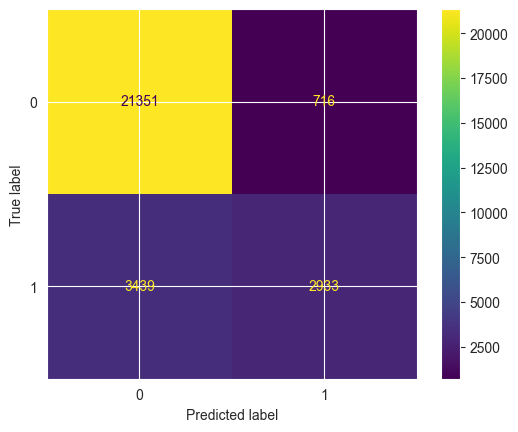

Pipeline(steps=[('preproc',
                 FeatureUnion(transformer_list=[('num_pipe',
                                                 Pipeline(steps=[('num_selector',
                                                                  ColumnSelector(dtype='numerical')),
                                                                 ('num_imputer',
                                                                  SimpleImputer(fill_value=0,
                                                                                strategy='constant'))])),
                                                ('cat_pipe',
                                                 Pipeline(steps=[('cat_selector',
                                                                  ColumnSelector(dtype='categorical')),
                                                                 ('cat_imputer',
                                                                  SimpleImputer(fill_value='None',
                                                                                strategy='constant')),
                                                                 ['ohe',
                                                                  OneHotEncoder(handle_unknown='ignore',
                                                                                sparse_output=False)]]))])),
                ('model', RandomForestClassifier(n_jobs=-1, random_state=42))])

In [66]:
get_null_accuracy(wdf)
X_train, X_test, y_train, y_test = split_data(wdf)

fit_and_evaluate(estimator_pipeline, X_train, y_train, X_test, y_test)

## Hyperparameter Tuning

In [67]:
estimator_pipeline.get_params()

{'memory': None,
 'steps': [('preproc',
   FeatureUnion(transformer_list=[('num_pipe',
                                   Pipeline(steps=[('num_selector',
                                                    ColumnSelector(dtype='numerical')),
                                                   ('num_imputer',
                                                    SimpleImputer(fill_value=0,
                                                                  strategy='constant'))])),
                                  ('cat_pipe',
                                   Pipeline(steps=[('cat_selector',
                                                    ColumnSelector(dtype='categorical')),
                                                   ('cat_imputer',
                                                    SimpleImputer(fill_value='None',
                                                                  strategy='constant')),
                                                   ['ohe',
             

In [13]:
from sklearn.model_selection import GridSearchCV

Null accuracy:  75.84%
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Train accuracy score: 100.00%
Test accuracy score: 85.68%


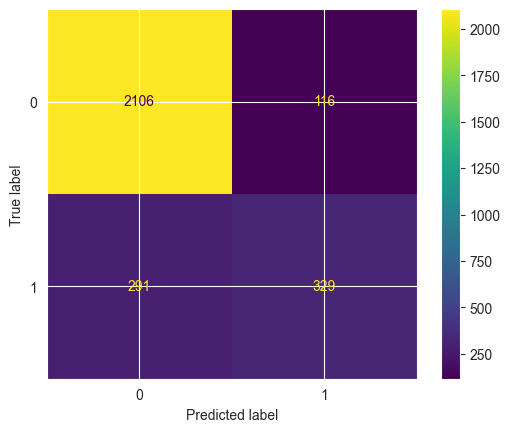

In [14]:
param_grid = {
    'preproc__num_pipe__num_imputer__strategy': ['median'],
    'preproc__cat_pipe__cat_imputer__strategy': ['most_frequent'],
    'model__max_features': ['sqrt', None],
    # 'model__n_estimators': [100, 500],
    # 'model__max_depth': [10, 50, 100, None],
    'model__class_weight': [None, 'balanced']
}

grid = GridSearchCV(estimator_pipeline, param_grid, scoring="accuracy", n_jobs=10, cv=5, verbose=2)

get_null_accuracy(wdf)
X_train, X_test, y_train, y_test = split_data(wdf.sample(frac=.1))

grid = fit_and_evaluate(grid, X_train, y_train, X_test, y_test)

In [18]:
pd.concat(
    [
        pd.DataFrame(grid.cv_results_["params"]),
        pd.DataFrame(grid.cv_results_["mean_test_score"], columns=["Accuracy"])
    ],
    axis=1
)

,model__class_weight,model__max_features,preproc__cat_pipe__cat_imputer__strategy,preproc__num_pipe__num_imputer__strategy,Accuracy
0,None,sqrt,most_frequent,median,0.838993
1,None,None,most_frequent,median,0.841721
2,balanced,sqrt,most_frequent,median,0.837674
3,balanced,None,most_frequent,median,0.838906


## 💀 Exercise

Use the Kaggle houseing dataset [HERE](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data) to:

- Predict the housing prices.
- Compare [Random forest regressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) with Linear regression
- Do a parameter tuning for both. 
- Do the necessary preprocessing (e.g. imputation). 